### Using Bayesian methods to fit HLMs with non-informative priors
Evan Edwards

In [1]:
# Imports
import pandas as pd
import bambi as bmb
import arviz as az
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Load dataset
PISA2018 = pd.read_csv("pisa2018.BayesBook.csv")

In [3]:
# Data processing: converting categorical values to numerical values
PISA2018['Female'] = PISA2018['Female'].replace({'Female': 1, 'Male': 0})

In [4]:
# Setting up the priors
priors = {
      'Female': bmb.Prior('Uniform', lower = min(PISA2018['Female']), upper = max(PISA2018['Female'])),
      'ESCS': bmb.Prior('Logistic', mu = PISA2018['ESCS'].mean())
}

In [5]:
# The formula for the HLM
model_formula = 'PV1MATH ~ 1 + Female + ESCS + (1|SchoolID)'

# Initialize the model
model = bmb.Model(model_formula, data = PISA2018, priors = priors)

# Getting the fit model
trace = model.fit()

C:\Users\Evan Edwards\AppData\Roaming\Python\Python311\site-packages\pytensor\tensor\rewriting\elemwise.py:1028: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Evan Edwards\AppData\Roaming\Python\Python311\site-packages\pytensor\tensor\rewriting\elemwise.py:1028: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [PV1MATH_sigma, Intercept, Female, ESCS, 1|SchoolID_sigma, 1|SchoolID_offset]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 190 seconds.


In [6]:
# Printing a summary of the fit model
print(az.summary(trace))

                         mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept             471.647   2.794  466.284  476.967      0.067    0.048   
ESCS                   25.387   1.314   22.922   27.808      0.019    0.014   
PV1MATH_sigma          79.133   0.819   77.572   80.625      0.010    0.007   
Female                  0.504   0.293    0.062    1.000      0.004    0.003   
1|SchoolID_sigma       32.391   2.245   28.196   36.668      0.062    0.044   
...                       ...     ...      ...      ...        ...      ...   
1|SchoolID[84000169]  -11.290  13.036  -34.729   13.958      0.167    0.184   
1|SchoolID[84000171]  -19.923  12.385  -43.155    3.449      0.163    0.135   
1|SchoolID[84000172]  -20.229  21.776  -62.629   18.998      0.270    0.278   
1|SchoolID[84000173]    7.273  15.590  -21.131   36.601      0.197    0.280   
1|SchoolID[84000175]   -0.722  13.773  -27.165   26.101      0.175    0.241   

                      ess_bulk  ess_tail  r_hat  
I

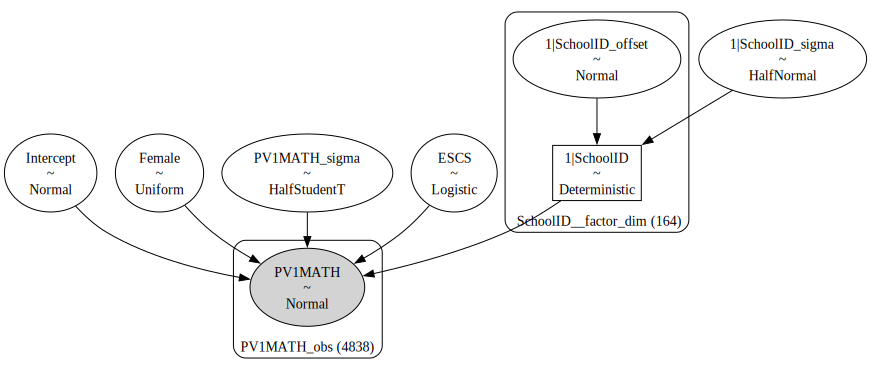

In [7]:
# Plotting a visualization of the model itself
model.graph()

Sampling: [1|SchoolID_sigma, ESCS, Female, Intercept, PV1MATH_sigma]


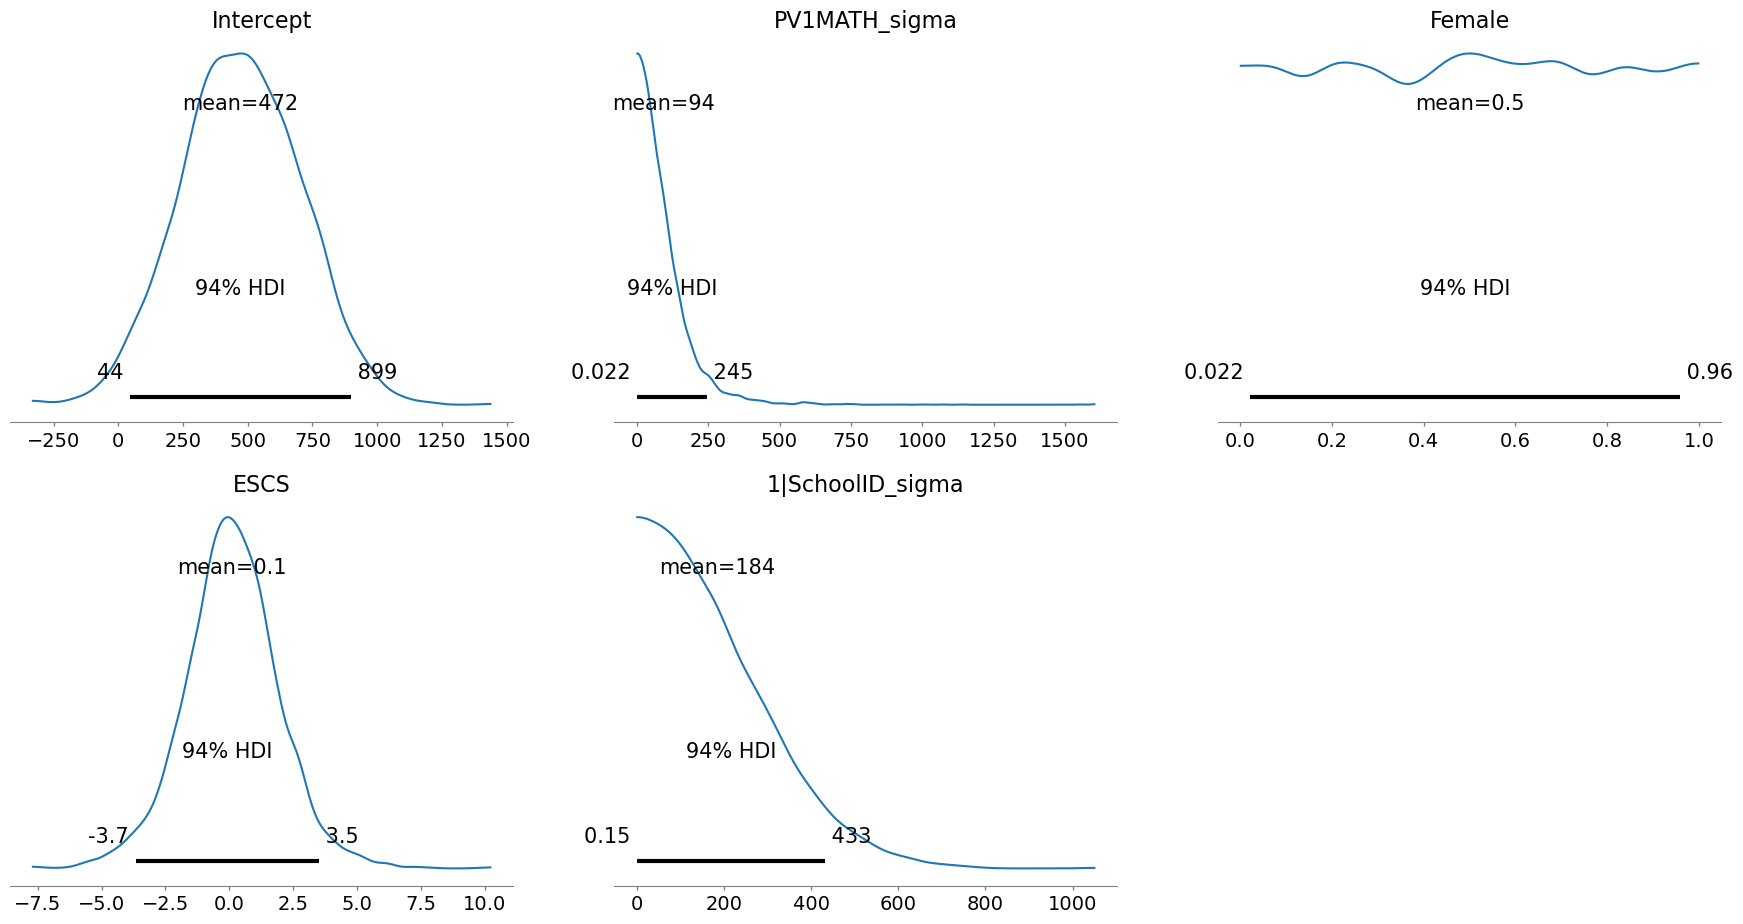

In [8]:
# Plotting the priors used
model.plot_priors()
plt.show()

In [9]:
# Creating the PV1MATH predictions using the model, and calculating the R^2 score and MSE as metrics of accuracy

# Making predictions on the training data
pred = bmb.interpret.predictions(model,trace)['estimate']

# Printing the accuracy metrics
print(f'The R^2 score is: {r2_score(PISA2018["PV1MATH"], pred)}')
print(f'The MSE is: {mean_squared_error(PISA2018["PV1MATH"], pred)}')

The R^2 score is: 0.2760522778132909
The MSE is: 6086.169373867461


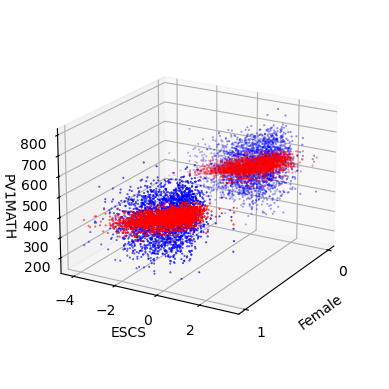

In [10]:
# Plotting the results in 3D, showing the predicted values in red
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.view_init(elev=20, azim=30)
ax.scatter3D(PISA2018["Female"], PISA2018["ESCS"], PISA2018["PV1MATH"], s=0.2, c="blue")
ax.scatter3D(PISA2018["Female"], PISA2018["ESCS"], pred, s=0.2, c="red")
ax.set_xlabel("Female")
ax.set_ylabel('ESCS')
ax.set_zlabel("PV1MATH")
ax.set_xticks([0, 1])
ax.set_box_aspect(None, zoom=0.85)
plt.show()